루브릭 1. 이미지 분류기 모델이 성공적으로 만들어졌는가?  
학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음

루브릭 2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?  
오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음

루브릭 3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
60% 이상 도달하였음


# 사전 작업

## 모듈 불러오기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from PIL import Image
import glob

In [2]:
print(tf.__version__)
print(np.__version__)

2.9.1
1.22.3


## helper function 정의하기

In [3]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [4]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


## 데이터 전처리

https://teachablemachine.withgoogle.com/

Github

├── aiffel_explorations

    ├── 05.ipynb

    └── .git

└── data

    └── exploration_05

        ├── data_300

            ├── scissors

            ├── rock

            └── paper

        ├── data_2100

            ├── scissors

            ├── rock

            └── paper

        ├── images_28x28

        ├── change_filenames.ipynb

        ├── data_300.zip

        ├── data_2100.zip

        └── readme.text

9월 30일 오전 6시 경, 아이펠에 출근하기 전에 집에서 내 손을 찍었다.
바위 100장, 가위 100장, 보 100장의 사진을 찍었다.
이 사진들을, 위의 트리에서 "GitHub/data/exploration_05/data_300" 안에 있는 세 폴더 "rock", "scissors", "paper"에 각각 넣어놓았다.
그리고 data_300 폴더는 통째로 압축하여 (반디집) data_300.zip 파일로 "GitHub/data/exploration_05" 안에 저장해놓았다.
이것은 원본 사진파일을 저장해놓기 위함이다.

## 모델 설정하기

모델은 다음과 같은 일정한 모델로 정한다.

In [5]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (No

In [6]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 실험(1) : 300개 데이터

## 데이터 할당하기

In [7]:
# resize_images("../data/exploration_05/data_300/scissors")
# resize_images("../data/exploration_05/data_300/rock")
# resize_images("../data/exploration_05/data_300/paper")

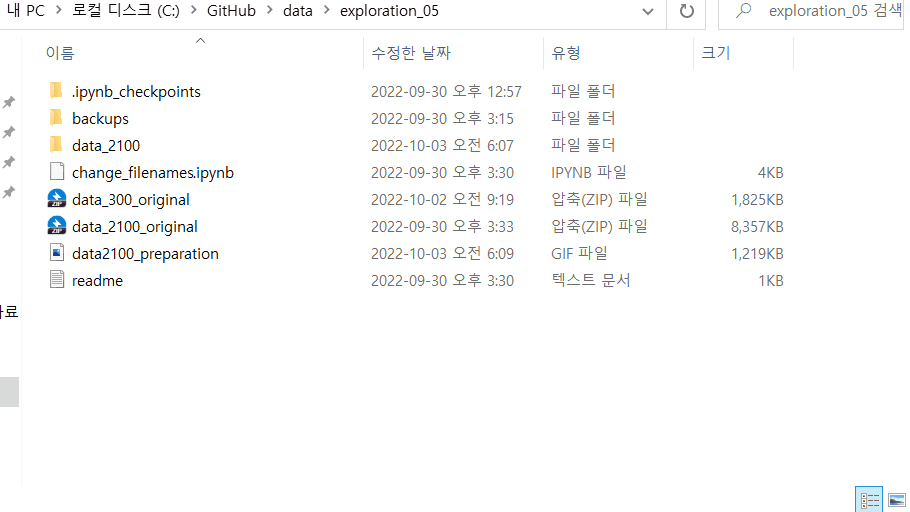

위의 세 개의 `resize_image(...)`를 선언하여, 원본 이미지를 resize하여 저장해놓는다.

In [8]:
X, y = load_data("../data/exploration_05/data_300",300)

학습데이터(x_train)의 이미지 개수는 300 입니다.


In [9]:
arr = np.arange(300)
np.random.shuffle(arr)

[0 0 2 1 0 2]


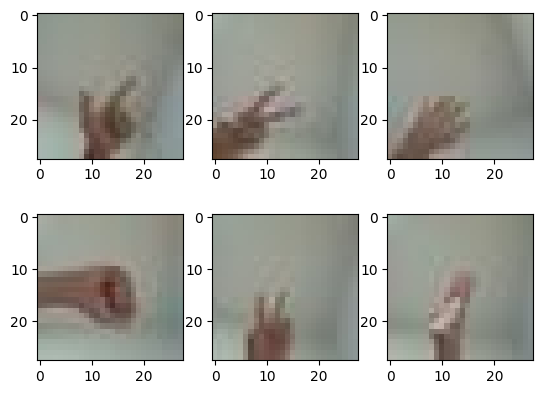

In [10]:
plt.subplot(231)
plt.imshow(X[arr][0])
plt.subplot(232)
plt.imshow(X[arr][1])
plt.subplot(233)
plt.imshow(X[arr][2])
plt.subplot(234)
plt.imshow(X[arr][3])
plt.subplot(235)
plt.imshow(X[arr][4])
plt.subplot(236)
plt.imshow(X[arr][5])
print(y[arr][:6])

In [11]:
X_train = X[:250]
X_test  = X[250:]
y_train = y[:250]
y_test  = y[250:]

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(250, 28, 28, 3)
(50, 28, 28, 3)
(250,)
(50,)


## 실험 (정규화 하지 않음)

In [13]:
n_epochs = 300

In [14]:
hist = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = n_epochs)

Epoch 1/300
8/8 [==============================] - 1s 71ms/step - loss: 37.2601 - accuracy: 0.3520 - val_loss: 4.5956 - val_accuracy: 0.1800
Epoch 2/300
8/8 [==============================] - 0s 12ms/step - loss: 5.8240 - accuracy: 0.4560 - val_loss: 12.9531 - val_accuracy: 0.0000e+00
Epoch 3/300
8/8 [==============================] - 0s 14ms/step - loss: 3.4477 - accuracy: 0.5080 - val_loss: 7.7825 - val_accuracy: 0.0000e+00
Epoch 4/300
8/8 [==============================] - 0s 20ms/step - loss: 2.5454 - accuracy: 0.6000 - val_loss: 4.9176 - val_accuracy: 0.1200
Epoch 5/300
8/8 [==============================] - 0s 13ms/step - loss: 1.5088 - accuracy: 0.6760 - val_loss: 8.9278 - val_accuracy: 0.0000e+00
Epoch 6/300
8/8 [==============================] - 0s 13ms/step - loss: 1.3693 - accuracy: 0.6960 - val_loss: 4.4396 - val_accuracy: 0.1800
Epoch 7/300
8/8 [==============================] - 0s 14ms/step - loss: 1.2703 - accuracy: 0.6880 - val_loss: 2.3229 - val_accuracy: 0.2800
Epoch 

8/8 [==============================] - 0s 13ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 1.8974 - val_accuracy: 0.5200
Epoch 60/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.3414 - val_accuracy: 0.6800
Epoch 61/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 1.9242 - val_accuracy: 0.5200
Epoch 62/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 2.2226 - val_accuracy: 0.4200
Epoch 63/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 1.8636 - val_accuracy: 0.5800
Epoch 64/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 1.8664 - val_accuracy: 0.5800
Epoch 65/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 1.6238 - val_accuracy: 0.6400
Epoch 66/300
8/8 [========

8/8 [==============================] - 0s 16ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.0438 - val_accuracy: 0.5800
Epoch 118/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.8727 - val_accuracy: 0.6600
Epoch 119/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.0161 - val_accuracy: 0.5800
Epoch 120/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.0387 - val_accuracy: 0.5800
Epoch 121/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.0679 - val_accuracy: 0.5800
Epoch 122/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.8973 - val_accuracy: 0.6600
Epoch 123/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.0831 - val_accuracy: 0.5800
Epoch 124/300
8/8 [=

Epoch 175/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.1141 - val_accuracy: 0.6400
Epoch 176/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.1476 - val_accuracy: 0.6200
Epoch 177/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.1568 - val_accuracy: 0.6400
Epoch 178/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.1399 - val_accuracy: 0.6400
Epoch 179/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.0881 - val_accuracy: 0.6600
Epoch 180/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.2272 - val_accuracy: 0.5600
Epoch 181/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.0934 - val_accuracy: 0.6400
Epoch 

Epoch 233/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.2052 - val_accuracy: 0.6600
Epoch 234/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.2669 - val_accuracy: 0.6400
Epoch 235/300
8/8 [==============================] - 0s 14ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.2934 - val_accuracy: 0.6400
Epoch 236/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.2336 - val_accuracy: 0.6600
Epoch 237/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.2407 - val_accuracy: 0.6400
Epoch 238/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.3217 - val_accuracy: 0.6200
Epoch 239/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.2110 - val_accuracy: 0.6600
Epoch 

8/8 [==============================] - 0s 15ms/step - loss: 6.9499e-04 - accuracy: 1.0000 - val_loss: 2.3449 - val_accuracy: 0.6600
Epoch 290/300
8/8 [==============================] - 0s 16ms/step - loss: 6.8084e-04 - accuracy: 1.0000 - val_loss: 2.3946 - val_accuracy: 0.6400
Epoch 291/300
8/8 [==============================] - 0s 15ms/step - loss: 6.7309e-04 - accuracy: 1.0000 - val_loss: 2.3218 - val_accuracy: 0.6400
Epoch 292/300
8/8 [==============================] - 0s 13ms/step - loss: 6.8864e-04 - accuracy: 1.0000 - val_loss: 2.4289 - val_accuracy: 0.6200
Epoch 293/300
8/8 [==============================] - 0s 12ms/step - loss: 6.6023e-04 - accuracy: 1.0000 - val_loss: 2.3525 - val_accuracy: 0.6400
Epoch 294/300
8/8 [==============================] - 0s 13ms/step - loss: 6.5940e-04 - accuracy: 1.0000 - val_loss: 2.4159 - val_accuracy: 0.6400
Epoch 295/300
8/8 [==============================] - 0s 17ms/step - loss: 6.5586e-04 - accuracy: 1.0000 - val_loss: 2.3247 - val_accuracy:

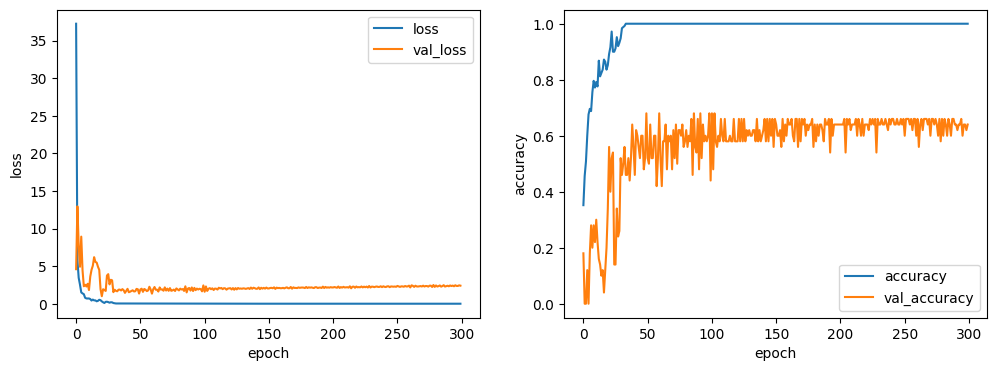

In [15]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

In [16]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 13ms/step - loss: 2.4041 - accuracy: 0.6400


[2.4041357040405273, 0.6399999856948853]

## 실험 (정규화 함)

In [17]:
X_train_norm = X_train/255.0
X_test_norm  = X_test/255.0

In [18]:
hist = model.fit(X_train_norm, y_train, validation_data = (X_test_norm,y_test), epochs = n_epochs)

Epoch 1/300
8/8 [==============================] - 1s 58ms/step - loss: 1.0603 - accuracy: 0.9200 - val_loss: 1.1474 - val_accuracy: 0.0000e+00
Epoch 2/300
8/8 [==============================] - 0s 13ms/step - loss: 1.0432 - accuracy: 0.8000 - val_loss: 1.2546 - val_accuracy: 0.0000e+00
Epoch 3/300
8/8 [==============================] - 0s 12ms/step - loss: 1.0287 - accuracy: 0.8000 - val_loss: 1.3608 - val_accuracy: 0.0000e+00
Epoch 4/300
8/8 [==============================] - 0s 13ms/step - loss: 1.0184 - accuracy: 0.7920 - val_loss: 1.4318 - val_accuracy: 0.0000e+00
Epoch 5/300
8/8 [==============================] - 0s 23ms/step - loss: 1.0129 - accuracy: 0.7800 - val_loss: 1.4978 - val_accuracy: 0.0000e+00
Epoch 6/300
8/8 [==============================] - 0s 13ms/step - loss: 1.0099 - accuracy: 0.6280 - val_loss: 1.5465 - val_accuracy: 0.0000e+00
Epoch 7/300
8/8 [==============================] - 0s 32ms/step - loss: 1.0063 - accuracy: 0.7000 - val_loss: 1.5285 - val_accuracy: 0.0

8/8 [==============================] - 0s 13ms/step - loss: 0.4116 - accuracy: 0.8440 - val_loss: 1.5034 - val_accuracy: 0.1200
Epoch 59/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4120 - accuracy: 0.8440 - val_loss: 1.3773 - val_accuracy: 0.1800
Epoch 60/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4178 - accuracy: 0.8680 - val_loss: 1.3702 - val_accuracy: 0.1800
Epoch 61/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4313 - accuracy: 0.8440 - val_loss: 1.2476 - val_accuracy: 0.1800
Epoch 62/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4417 - accuracy: 0.8120 - val_loss: 1.2005 - val_accuracy: 0.1600
Epoch 63/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4031 - accuracy: 0.8520 - val_loss: 1.4278 - val_accuracy: 0.1800
Epoch 64/300
8/8 [==============================] - 0s 14ms/step - loss: 0.3895 - accuracy: 0.8560 - val_loss: 1.4507 - val_accuracy: 0.1800
Epoch 65/300
8/8 [========

8/8 [==============================] - 0s 13ms/step - loss: 0.2752 - accuracy: 0.9280 - val_loss: 1.0902 - val_accuracy: 0.3800
Epoch 117/300
8/8 [==============================] - 0s 13ms/step - loss: 0.2571 - accuracy: 0.9320 - val_loss: 1.1692 - val_accuracy: 0.3600
Epoch 118/300
8/8 [==============================] - 0s 12ms/step - loss: 0.2560 - accuracy: 0.9320 - val_loss: 1.0606 - val_accuracy: 0.4000
Epoch 119/300
8/8 [==============================] - 0s 13ms/step - loss: 0.2556 - accuracy: 0.9280 - val_loss: 1.2066 - val_accuracy: 0.3400
Epoch 120/300
8/8 [==============================] - 0s 13ms/step - loss: 0.2616 - accuracy: 0.9280 - val_loss: 1.0733 - val_accuracy: 0.4000
Epoch 121/300
8/8 [==============================] - 0s 12ms/step - loss: 0.2453 - accuracy: 0.9360 - val_loss: 1.1232 - val_accuracy: 0.4200
Epoch 122/300
8/8 [==============================] - 0s 13ms/step - loss: 0.2423 - accuracy: 0.9360 - val_loss: 1.0093 - val_accuracy: 0.4200
Epoch 123/300
8/8 [=

Epoch 174/300
8/8 [==============================] - 0s 13ms/step - loss: 0.1066 - accuracy: 0.9680 - val_loss: 0.5101 - val_accuracy: 0.7000
Epoch 175/300
8/8 [==============================] - 0s 12ms/step - loss: 0.1106 - accuracy: 0.9680 - val_loss: 0.7939 - val_accuracy: 0.6800
Epoch 176/300
8/8 [==============================] - 0s 13ms/step - loss: 0.1076 - accuracy: 0.9720 - val_loss: 0.6984 - val_accuracy: 0.7000
Epoch 177/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0977 - accuracy: 0.9800 - val_loss: 0.7687 - val_accuracy: 0.6800
Epoch 178/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0970 - accuracy: 0.9680 - val_loss: 0.5633 - val_accuracy: 0.7000
Epoch 179/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0943 - accuracy: 0.9800 - val_loss: 0.8517 - val_accuracy: 0.7000
Epoch 180/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0958 - accuracy: 0.9680 - val_loss: 0.4911 - val_accuracy: 0.7000
Epoch 

Epoch 232/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.5968 - val_accuracy: 0.7000
Epoch 233/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.6272 - val_accuracy: 0.7000
Epoch 234/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 0.6413 - val_accuracy: 0.7000
Epoch 235/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.5907 - val_accuracy: 0.7000
Epoch 236/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.6915 - val_accuracy: 0.7000
Epoch 237/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0321 - accuracy: 1.0000 - val_loss: 0.6698 - val_accuracy: 0.7000
Epoch 238/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.5621 - val_accuracy: 0.7000
Epoch 

Epoch 290/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.7148 - val_accuracy: 0.7600
Epoch 291/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.7539 - val_accuracy: 0.7400
Epoch 292/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.7076 - val_accuracy: 0.7600
Epoch 293/300
8/8 [==============================] - 0s 13ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.7557 - val_accuracy: 0.7400
Epoch 294/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.7607 - val_accuracy: 0.7400
Epoch 295/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.8039 - val_accuracy: 0.7400
Epoch 296/300
8/8 [==============================] - 0s 12ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.6991 - val_accuracy: 0.7600
Epoch 

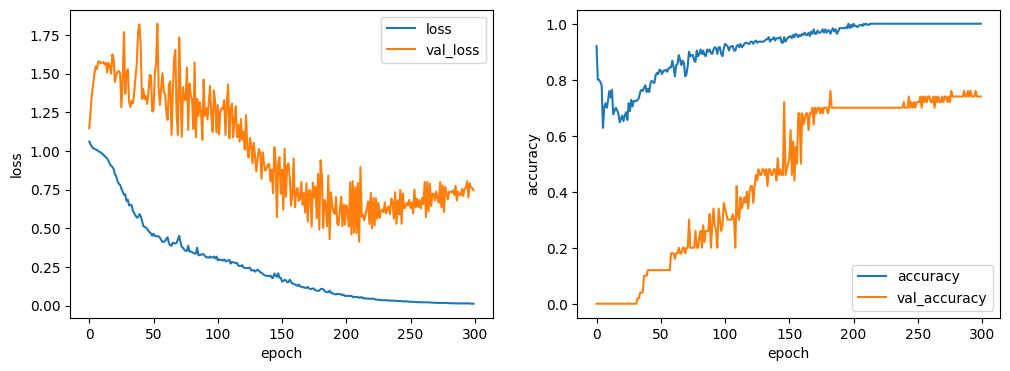

In [19]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

In [20]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 12ms/step - loss: 5.7733 - accuracy: 0.8800


[5.773284435272217, 0.8799999952316284]

# 실험(2) : 2100개 데이터

## 데이터 할당하기

In [21]:
# resize_images("../data/exploration_05/data_2100/scissors")
# resize_images("../data/exploration_05/data_2100/rock")
# resize_images("../data/exploration_05/data_2100/paper")

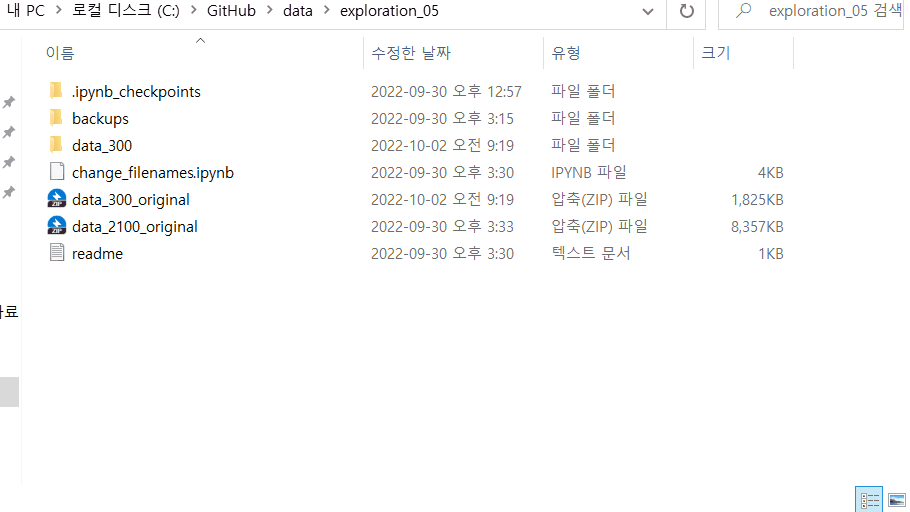

위의 세 개의 `resize_image(...)`를 선언하여, 원본 이미지를 resize하여 저장해놓는다.

In [22]:
X, y = load_data("../data/exploration_05/data_2100",2100)

학습데이터(x_train)의 이미지 개수는 2100 입니다.


In [23]:
arr = np.arange(2100)
np.random.shuffle(arr)

[0 2 1 0 1 2]


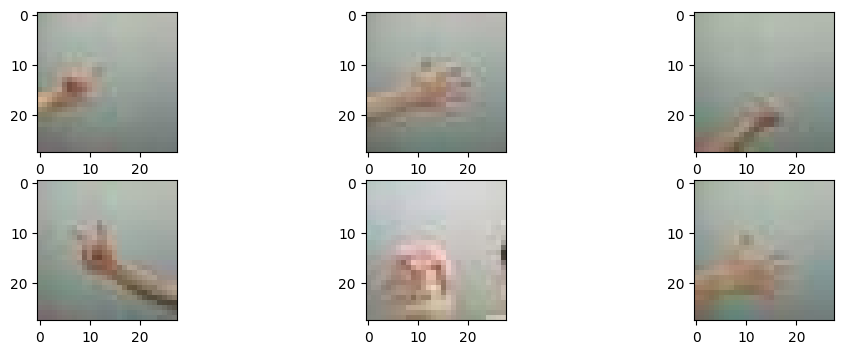

In [24]:
plt.subplot(231)
plt.imshow(X[arr][0])
plt.subplot(232)
plt.imshow(X[arr][1])
plt.subplot(233)
plt.imshow(X[arr][2])
plt.subplot(234)
plt.imshow(X[arr][3])
plt.subplot(235)
plt.imshow(X[arr][4])
plt.subplot(236)
plt.imshow(X[arr][5])
print(y[arr][:6])

In [25]:
X_train = X[:1700] # 약 80%
X_test  = X[1700:]
y_train = y[:1700]
y_test  = y[1700:]

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1700, 28, 28, 3)
(400, 28, 28, 3)
(1700,)
(400,)


## 실험 (정규화 하지 않음)

In [27]:
n_epochs = 300

In [28]:
hist = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = n_epochs)

Epoch 1/300
54/54 [==============================] - 0s 9ms/step - loss: 22.4882 - accuracy: 0.3035 - val_loss: 1.1622 - val_accuracy: 0.0000e+00
Epoch 2/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0652 - accuracy: 0.4124 - val_loss: 1.4521 - val_accuracy: 0.0000e+00
Epoch 3/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0418 - accuracy: 0.4124 - val_loss: 1.6164 - val_accuracy: 0.0000e+00
Epoch 4/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0374 - accuracy: 0.4124 - val_loss: 1.6900 - val_accuracy: 0.0000e+00
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4053 - val_loss: 1.7211 - val_accuracy: 0.0000e+00
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4029 - val_loss: 1.7323 - val_accuracy: 0.0000e+00
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0366 - accuracy: 0.4124 - val_loss: 1.7373 - val_accur

54/54 [==============================] - 0s 8ms/step - loss: 1.0364 - accuracy: 0.3947 - val_loss: 1.7335 - val_accuracy: 0.0000e+00
Epoch 58/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4124 - val_loss: 1.7399 - val_accuracy: 0.0000e+00
Epoch 59/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4100 - val_loss: 1.7291 - val_accuracy: 0.0000e+00
Epoch 60/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4118 - val_loss: 1.7198 - val_accuracy: 0.0000e+00
Epoch 61/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4071 - val_loss: 1.7305 - val_accuracy: 0.0000e+00
Epoch 62/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4124 - val_loss: 1.7207 - val_accuracy: 0.0000e+00
Epoch 63/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0366 - accuracy: 0.4124 - val_loss: 1.7260 - val_accuracy: 0.

54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.3994 - val_loss: 1.7344 - val_accuracy: 0.0000e+00
Epoch 114/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0366 - accuracy: 0.3847 - val_loss: 1.7316 - val_accuracy: 0.0000e+00
Epoch 115/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.4118 - val_loss: 1.7343 - val_accuracy: 0.0000e+00
Epoch 116/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0364 - accuracy: 0.4118 - val_loss: 1.7155 - val_accuracy: 0.0000e+00
Epoch 117/300
54/54 [==============================] - 1s 10ms/step - loss: 1.0366 - accuracy: 0.3924 - val_loss: 1.7254 - val_accuracy: 0.0000e+00
Epoch 118/300
54/54 [==============================] - 0s 9ms/step - loss: 1.0365 - accuracy: 0.4118 - val_loss: 1.7329 - val_accuracy: 0.0000e+00
Epoch 119/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0364 - accuracy: 0.4118 - val_loss: 1.7363 - val_accur

Epoch 169/300
54/54 [==============================] - 0s 9ms/step - loss: 1.0369 - accuracy: 0.4124 - val_loss: 1.7373 - val_accuracy: 0.0000e+00
Epoch 170/300
54/54 [==============================] - 0s 9ms/step - loss: 1.0364 - accuracy: 0.3935 - val_loss: 1.7345 - val_accuracy: 0.0000e+00
Epoch 171/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4065 - val_loss: 1.7322 - val_accuracy: 0.0000e+00
Epoch 172/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4124 - val_loss: 1.7443 - val_accuracy: 0.0000e+00
Epoch 173/300
54/54 [==============================] - 0s 9ms/step - loss: 1.0365 - accuracy: 0.4053 - val_loss: 1.7322 - val_accuracy: 0.0000e+00
Epoch 174/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4124 - val_loss: 1.7489 - val_accuracy: 0.0000e+00
Epoch 175/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4012 - val_loss: 1.745

Epoch 225/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4065 - val_loss: 1.7227 - val_accuracy: 0.0000e+00
Epoch 226/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4124 - val_loss: 1.7324 - val_accuracy: 0.0000e+00
Epoch 227/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0364 - accuracy: 0.4041 - val_loss: 1.7397 - val_accuracy: 0.0000e+00
Epoch 228/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4053 - val_loss: 1.7345 - val_accuracy: 0.0000e+00
Epoch 229/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0366 - accuracy: 0.4118 - val_loss: 1.7468 - val_accuracy: 0.0000e+00
Epoch 230/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0366 - accuracy: 0.4035 - val_loss: 1.7217 - val_accuracy: 0.0000e+00
Epoch 231/300
54/54 [==============================] - 0s 9ms/step - loss: 1.0365 - accuracy: 0.3953 - val_loss: 1.728

Epoch 281/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4100 - val_loss: 1.7320 - val_accuracy: 0.0000e+00
Epoch 282/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0366 - accuracy: 0.4147 - val_loss: 1.7308 - val_accuracy: 0.0000e+00
Epoch 283/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4118 - val_loss: 1.7431 - val_accuracy: 0.0000e+00
Epoch 284/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0366 - accuracy: 0.4094 - val_loss: 1.7387 - val_accuracy: 0.0000e+00
Epoch 285/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4065 - val_loss: 1.7190 - val_accuracy: 0.0000e+00
Epoch 286/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0365 - accuracy: 0.4118 - val_loss: 1.7334 - val_accuracy: 0.0000e+00
Epoch 287/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0367 - accuracy: 0.4071 - val_loss: 1.727

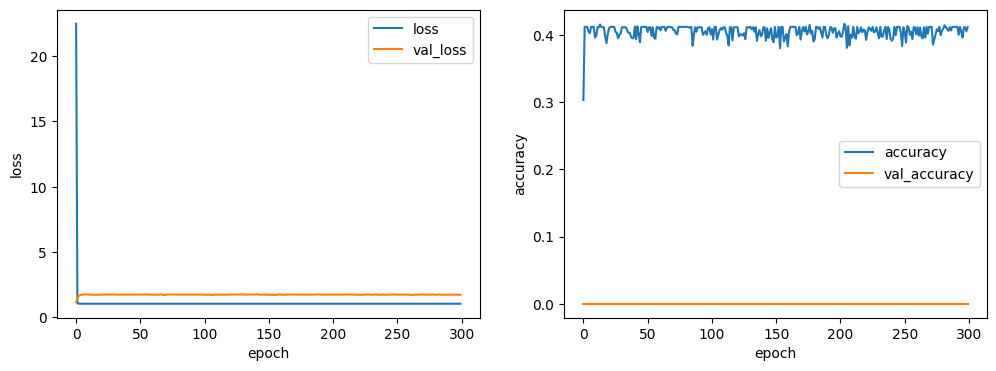

In [29]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

In [30]:
model.evaluate(X_test,y_test)

13/13 [==============================] - 0s 4ms/step - loss: 1.7212 - accuracy: 0.0000e+00


[1.721166729927063, 0.0]

## 실험 (정규화 함)

In [31]:
X_train_norm = X_train/255.0
X_test_norm  = X_test/255.0

In [32]:
hist = model.fit(X_train_norm, y_train, validation_data = (X_test_norm,y_test), epochs = n_epochs)

Epoch 1/300
54/54 [==============================] - 1s 26ms/step - loss: 1.0442 - accuracy: 0.4035 - val_loss: 1.7215 - val_accuracy: 0.0000e+00
Epoch 2/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.4094 - val_loss: 1.7279 - val_accuracy: 0.0000e+00
Epoch 3/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.4118 - val_loss: 1.7331 - val_accuracy: 0.0000e+00
Epoch 4/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4035 - val_loss: 1.7329 - val_accuracy: 0.0000e+00
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4129 - val_loss: 1.7291 - val_accuracy: 0.0000e+00
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.4118 - val_loss: 1.7386 - val_accuracy: 0.0000e+00
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.3894 - val_loss: 1.7305 - val_accur

54/54 [==============================] - 0s 8ms/step - loss: 1.0372 - accuracy: 0.4153 - val_loss: 1.7186 - val_accuracy: 0.0000e+00
Epoch 58/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0373 - accuracy: 0.3971 - val_loss: 1.7315 - val_accuracy: 0.0000e+00
Epoch 59/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.4118 - val_loss: 1.7367 - val_accuracy: 0.0000e+00
Epoch 60/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0372 - accuracy: 0.3912 - val_loss: 1.7416 - val_accuracy: 0.0000e+00
Epoch 61/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.4094 - val_loss: 1.7361 - val_accuracy: 0.0000e+00
Epoch 62/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0372 - accuracy: 0.4094 - val_loss: 1.7365 - val_accuracy: 0.0000e+00
Epoch 63/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4094 - val_loss: 1.7461 - val_accuracy: 0.

54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.4041 - val_loss: 1.7325 - val_accuracy: 0.0000e+00
Epoch 114/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.3947 - val_loss: 1.7275 - val_accuracy: 0.0000e+00
Epoch 115/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4106 - val_loss: 1.7256 - val_accuracy: 0.0000e+00
Epoch 116/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4118 - val_loss: 1.7275 - val_accuracy: 0.0000e+00
Epoch 117/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.4118 - val_loss: 1.7366 - val_accuracy: 0.0000e+00
Epoch 118/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4118 - val_loss: 1.7320 - val_accuracy: 0.0000e+00
Epoch 119/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.3900 - val_loss: 1.7345 - val_accura

Epoch 169/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0372 - accuracy: 0.3959 - val_loss: 1.7386 - val_accuracy: 0.0000e+00
Epoch 170/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.3982 - val_loss: 1.7378 - val_accuracy: 0.0000e+00
Epoch 171/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.3888 - val_loss: 1.7402 - val_accuracy: 0.0000e+00
Epoch 172/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0372 - accuracy: 0.3941 - val_loss: 1.7305 - val_accuracy: 0.0000e+00
Epoch 173/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4024 - val_loss: 1.7275 - val_accuracy: 0.0000e+00
Epoch 174/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.4059 - val_loss: 1.7185 - val_accuracy: 0.0000e+00
Epoch 175/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0371 - accuracy: 0.3912 - val_loss: 1.728

Epoch 225/300
54/54 [==============================] - 0s 9ms/step - loss: 1.0369 - accuracy: 0.4118 - val_loss: 1.7313 - val_accuracy: 0.0000e+00
Epoch 226/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0372 - accuracy: 0.4118 - val_loss: 1.7424 - val_accuracy: 0.0000e+00
Epoch 227/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.4135 - val_loss: 1.7374 - val_accuracy: 0.0000e+00
Epoch 228/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4118 - val_loss: 1.7348 - val_accuracy: 0.0000e+00
Epoch 229/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.4118 - val_loss: 1.7431 - val_accuracy: 0.0000e+00
Epoch 230/300
54/54 [==============================] - 0s 9ms/step - loss: 1.0371 - accuracy: 0.4118 - val_loss: 1.7378 - val_accuracy: 0.0000e+00
Epoch 231/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.4018 - val_loss: 1.752

Epoch 281/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.3929 - val_loss: 1.7271 - val_accuracy: 0.0000e+00
Epoch 282/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.3965 - val_loss: 1.7382 - val_accuracy: 0.0000e+00
Epoch 283/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4118 - val_loss: 1.7334 - val_accuracy: 0.0000e+00
Epoch 284/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4118 - val_loss: 1.7450 - val_accuracy: 0.0000e+00
Epoch 285/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4118 - val_loss: 1.7366 - val_accuracy: 0.0000e+00
Epoch 286/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0370 - accuracy: 0.4118 - val_loss: 1.7323 - val_accuracy: 0.0000e+00
Epoch 287/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0369 - accuracy: 0.4118 - val_loss: 1.741

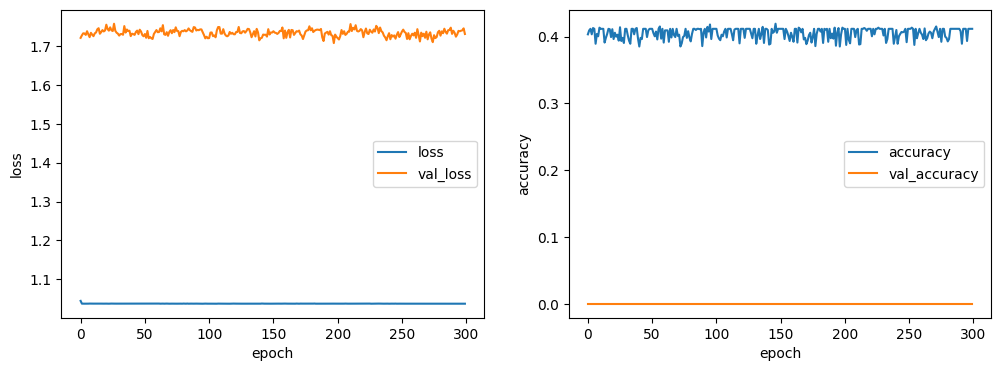

In [33]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

In [34]:
model.evaluate(X_test,y_test)

13/13 [==============================] - 0s 4ms/step - loss: 1.7315 - accuracy: 0.0000e+00


[1.7314691543579102, 0.0]